In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
'''
Simple 3 layer dense fully connected model allowing for layers
of any size.
'''
class dnn:
    def __init__(self, sizes, epochs=10, rate=0.001, weight_params=(0,0.1)):
        self.sizes = sizes
        self.epochs = epochs
        self.rate = rate
        
        mu = weight_params[0]
        sig = weight_params[1]
        self.weights = {
            'w1':np.random.normal(mu,sig,size=(sizes[1],sizes[0])),
            'w2':np.random.normal(mu,sig,size=(sizes[2],sizes[1]))
        }
        print("initial w1:")
        print(self.weights['w1'])
        print("initial w2:")
        print(self.weights['w2'])
    '''
    Return sigmoid function output with option for derivative
    '''
    def sigmoid(self, val, der=False):
        sig = 1/(1+np.exp(-val))
        if der:
            return sig*(1-sig)
        else:
            return sig
    
    '''
    Return softmax function output with option for derivative
    '''
    def softmax(self, val, der=False): # found online at [1] for stability
        exp = np.exp(val - val.max())
        sig = exp/np.sum(exp,axis=0)
        if der:
            return sig*(1-sig)
        else:
            return sig
    
    '''
    Calculates the forward pass of a network
    '''
    def forward(self, x):
        weights = self.weights
        weights['a0'] = x
        
        weights['z1'] = np.dot(weights['w1'],weights['a0'])
        weights['a1'] = self.sigmoid(weights['z1'])
        
        weights['z2'] = np.dot(weights['w2'],weights['a1'])
        weights['a2'] = self.softmax(weights['z2'])
        
        return weights['a2']
    
    '''
    Calculates the backpropagation of the network and returns the 
    gradient for the weights
    '''
    def backward(self, y_train, y_pred):
        weights = self.weights
        delta_w = {} # create an empty set to store weight grads
        
        err = (y_pred-y_train)/y_pred.shape[0]*self.softmax(weights['z2'],der=True)
        delta_w['w2'] = np.outer(err,weights['a1'])
        
        err = np.dot(weights['w2'].T,err)*self.sigmoid(weights['z1'],der=True)
        delta_w['w1'] = np.outer(err,weights['a0'])
        
        return delta_w
    
    '''
    Update the weights using learning rate and gradient
    '''
    def update(self,deltas):
        for key,val in deltas.items():
            self.weights[key] -= self.rate*val
    
    '''
    Calculate the accuracy of the current weights on testing data
    '''
    def accuracy(self, x_test, y_test):
        correct = np.zeros(len(y_test))
        for i,(x,y) in enumerate(zip(x_test,y_test)):
            out = self.forward(x)
            pred = np.argmax(out)
            correct[i] = 1*(pred==np.argmax(y))
        return np.mean(correct)
    
    def train(self,x_train,y_train,x_test,y_test):
        test_acc = []
        train_acc = []
        for it in range(self.epochs):
            shuffle = np.random.permutation(len(y_train)) #shuffle sgd
            for x,y in zip(x_train[shuffle],y_train[shuffle]):
                out = self.forward(x) # forward pass
                deltas = self.backward(y,out) # backpropegation
                self.update(deltas) # interate weights
            temp_test_acc = self.accuracy(x_test,y_test)
            temp_train_acc = self.accuracy(x_train,y_train)
            test_acc.append(temp_test_acc)
            train_acc.append(temp_train_acc)
        return train_acc,test_acc

1: [Link to code for stable softmax function](https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python)

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# convert labels to one-hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# scale data from 0-255 -> 0.0-1.0 to help with stability
x_train = (x_train.reshape(len(x_train),784)/255).astype('float32')
x_test = (x_test.reshape(len(x_test),784)/255).astype('float32')

In [5]:
clf = dnn(rate=0.01,epochs=10,sizes=[784,300,10],weight_params=(0,0.01))
train_acc,test_acc = clf.train(x_train,y_train,x_test,y_test)

w1:
[[-0.00043499  0.00125902 -0.00353918 ...  0.01695713  0.01038155
   0.02498683]
 [-0.00747192 -0.00660738  0.00282746 ...  0.00386523 -0.00979875
  -0.02121269]
 [-0.00162685  0.00788688  0.00030683 ... -0.01876108  0.01228094
  -0.01597862]
 ...
 [ 0.01865765 -0.004888   -0.02936259 ... -0.00187539 -0.00461378
  -0.0046217 ]
 [ 0.00149899  0.01768684 -0.00572025 ... -0.00068829  0.00848492
  -0.00301619]
 [ 0.00768285 -0.03659497  0.01122215 ... -0.00927037 -0.00343739
  -0.01138568]]
w2:
[[-0.00481194 -0.00383121  0.00093831 ...  0.02046944 -0.01905419
  -0.00750487]
 [-0.01055063 -0.00540094  0.01373389 ...  0.00075688  0.00132433
  -0.00333939]
 [-0.0028789   0.0033582  -0.01136629 ...  0.00520272  0.00278522
   0.00738701]
 ...
 [-0.00754042 -0.01911097 -0.00840039 ... -0.0033576  -0.00454132
  -0.01807097]
 [ 0.0042844   0.00768897  0.00987757 ... -0.00477413 -0.00368572
   0.0081552 ]
 [ 0.00107497 -0.00068034 -0.00085924 ... -0.0009239   0.00507851
   0.01873371]]


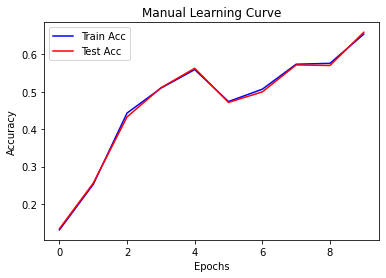

In [6]:
# plot testing accuracy
plt.plot(train_acc,color='b',label='Train Acc');
plt.plot(test_acc,color='r',label='Test Acc');
plt.legend()
plt.title("Manual Learning Curve");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");

### Using tensorflow to create same model as above

In [7]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(784,)),
    tf.keras.layers.Dense(300, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [8]:
model.compile(optimizer='sgd',
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test)).history

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7452 - accuracy: 0.5832 - val_loss: 0.7698 - val_accuracy: 0.8447
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7038 - accuracy: 0.8487 - val_loss: 0.5185 - val_accuracy: 0.8761
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5111 - accuracy: 0.8731 - val_loss: 0.4324 - val_accuracy: 0.8885
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4411 - accuracy: 0.8832 - val_loss: 0.3885 - val_accuracy: 0.8962
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4008 - accuracy: 0.8907 - val_loss: 0.3618 - val_accuracy: 0.9011
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3748 - accuracy: 0.8965 - val_loss: 0.3439 - val_accuracy: 0.9051
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3586 - accuracy: 0.8991 - val_loss: 0.3319 - val_accuracy:

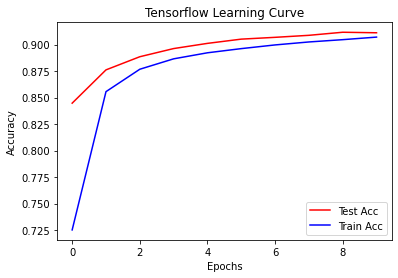

In [9]:
# plot testing accuracy
plt.plot(history['val_accuracy'],color='r',label='Test Acc');
plt.plot(history['accuracy'],color='b',label='Train Acc');
plt.legend()
plt.title("Tensorflow Learning Curve");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");